In [1]:
import os
import glob
import ray
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import functools as ft
import operator as op

In [2]:
os.chdir('/Users/sheg/Documents/projects/anki-flashcards/japanese/data')

# Загружаем предложения

In [3]:
with open('tatoeba/sentences_detailed.csv') as file:
    sent = pd.read_csv(file, delimiter='\t',
                       header=None, index_col=0,
                       names=['id', 'lang', 'text', 'user'],
                       usecols=[0, 1, 2, 3],
                       na_values=['\\N']
                      )

/usr/local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
sent = sent[sent.lang.isin(['rus', 'eng', 'jpn'])]
sent.lang.replace({'rus': 'ru', 'eng': 'en', 'jpn': 'jp'}, inplace=True)

In [5]:
with open('tatoeba/links.csv') as file:
    links = pd.read_csv(file, delimiter='\t', header=None)

In [6]:
grouped_links = links.groupby(by=0)[1].apply(set)

In [7]:
links = links[links.isin(sent.index).all(axis=1)]
links = links.reset_index(drop=True)

In [8]:
df = pd.concat([sent, grouped_links], axis=1).rename(columns={1: 'links'})
df.dropna(inplace=True)

In [9]:
del sent, grouped_links

# Отсеиваем лишние предложения

In [10]:
jp_ids = set(df[df.lang == 'jp'].index)
non_jp_ids = set(df[df.lang != 'jp'].index)

In [11]:
has_jp_link_ids = df.links.apply(lambda S: len(S & jp_ids) > 0)

In [12]:
js_has_translation_ids = df.links.apply(lambda S: len(S & non_jp_ids) > 0 ) & (df.lang == 'jp')

In [13]:
good_ids = set(df[has_jp_link_ids].index | df[js_has_translation_ids].index)

In [14]:
df = df.loc[good_ids]

In [15]:
df.links = df.links.apply(lambda S: S & good_ids)

In [16]:
sent = df
del df

In [17]:
sent.lang = sent.lang.astype('category')
sent.user = sent.user.astype('category')

In [18]:
sent.to_pickle('sent.pkl')

## Качество предложений

### Уровень владения языком

In [19]:
users_skill = pd.read_csv('tatoeba/user_languages.csv',
                          names=['lang', 'skill', 'user'],
                          usecols=[0, 1, 2],
                          delimiter='\t',
                          na_values=['\\N'],
                          dtype={'skill': 'Int8', 'lang': 'category', 'user': 'category'},
                          header=None
                         )

In [20]:
users_skill.dropna(inplace=True)

In [21]:
users_skill = users_skill[ users_skill.lang.isin(['rus', 'jap', 'eng']) ]

In [22]:
users_skill = users_skill[ users_skill.user.isin(sent.user) ]

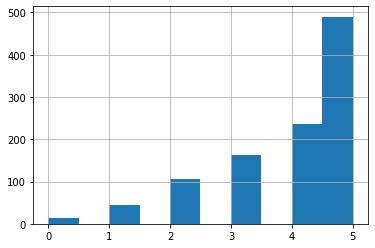

In [23]:
users_skill.skill.hist()
plt.show()

### Рейтинг предложения

In [24]:
rating = pd.read_csv('tatoeba/users_sentences.csv',
                     names=['user', 'id', 'rating'],
                     usecols=[0, 1, 2],
                     delimiter='\t',
                     header=None,
                     dtype={'user': 'str', 'rating': 'Int8'},
                     na_values=['\\N']
                     )

In [25]:
rating = rating[ rating.id.isin(sent.index) ]

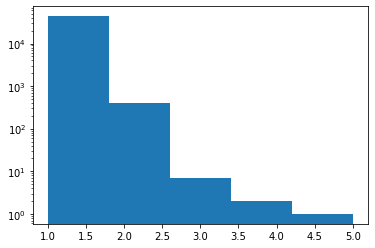

In [26]:
# Количество оценок по предложениям

plt.hist( rating.id.value_counts(), log=True, bins=5)
plt.show()

In [27]:
mean_rating = rating.groupby('id').aggregate({'rating': 'mean'})

In [28]:
sent = sent.join(mean_rating)

In [29]:
sent.to_pickle('sent.pkl')

# Аудио

In [30]:
sent_has_audio = pd.read_csv('tatoeba/sentences_with_audio.csv',
                         names=['id', 'user'],
                         usecols=[0, 1],
                         header=None,
                         dtype={'user': 'category'},
                         delimiter='\t',
                         index_col='id',
                         squeeze=True
                        )

In [31]:
sent_has_audio = sent_has_audio[sent_has_audio.index.isin(sent.index)]

In [32]:
# Только одно предложение имело две озвучки

sent_has_audio = sent_has_audio[~sent_has_audio.index.duplicated(keep='first')]

In [33]:
sent['audio'] = sent.index.isin(sent_has_audio.index)

In [34]:
sent.to_pickle('sent.pkl')